## Classical Diffusion Model ##

This architecture follows the quantum diffusion model structure, training the same number of parameters, using the same number of layers, and following the same complexity. It is used as a baseline for comparison between the classical and quantum models for the same tasks.

First, a classical model without the quantum layer but with the same shapes and encodings.

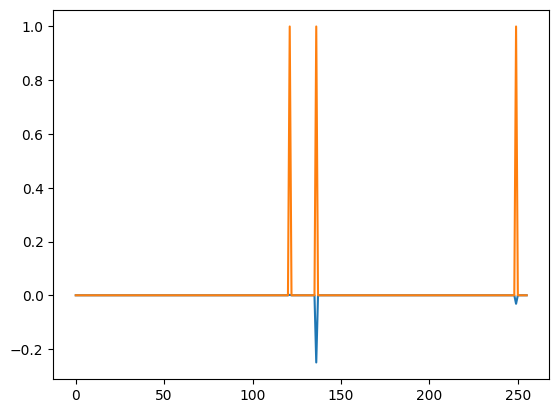

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py
import scipy.linalg

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/small_QG2_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    for i in range(len(encoded_data)):
        # scrambled_state = np.random.permutation(encoded_data[i].flatten())
        gaussian_matrix = np.random.normal(0, 0.1, (16, 16))
        scrambled_state = np.multiply(gaussian_matrix, encoded_data[i])
        scrambled_vectors.append(scrambled_state)
    return np.array(scrambled_vectors).reshape(len(encoded_data), 8, 8, 4)

def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = scrambled_states.reshape(scrambled_states.shape[0], 8, 8, 4)
    return reshaped_scrambled_states

def visualize_data(original_data, encoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(encoded_data[sample_index], cmap='viridis')
    axes[1].set_title("AAA Data")
    
    plt.tight_layout()
    plt.show()

class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_samples = 10000
num_epochs = 50
loss_values = []

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)
# plt.plot(scrambled_states[0])
plt.plot(scrambled_states[4])
plt.plot(encoded_data[4])

In [ ]:

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states)
    loss = criterion(outputs, encoded_data)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

denoised_states = model(scrambled_states).view(num_samples, 8, 8, 4).detach().numpy()
visualize_data(data_X, denoised_states, sample_index=0)

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

decoded_data = decode(denoised_states)
# decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_data(data_X, decoded_data, sample_index=0)

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # Flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            # print(generated_data)

            # decoded_images = flip(decode(generated_data))
            decoded_images = decode(generated_data)
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))

            # Display each channel separately
            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded Channel {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            # Combined visualization (if applicable)
            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded Image")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_new_images = 10
new_images = generate_new_images(model, num_new_images)


Notes for presentation:
- Tried on 10k samples --> cleaner output with less noise thank 1k samples
- Trained on 100k samples --> not much difference except slower convergence, but could tune hyperparameters for better performance; significantly slower sample generation
- Tried permutations which basically gives the same output as gaussian noise (do permutations follow a normal distribution?)

TODO:
Reshape data and model inputs to take in 3 channel data
- This involvess scrambling each of the channels with the same random unitary/gaussian matrix and get the model to learn distributions in sets of three 
- Make 100k datasets for QG2 and QG3

Questions:
- Is there a formula defining the relationship between the three channels? Do they have something in common they wouldn't share with the other channels? How do we verify we've generated the right channels (FID mean doesn't capture thet closeness between the three)?


In [3]:
# Make minimum numbers purple and max yellow
# Make sure the FID is an average

print(data_X.shape)

(100000, 16, 16)
